In [1]:
## basic modules
import os
import sys
import re
import xarray as xr
import glob
import numpy as np
import pandas as pd
import itertools ## need this for the cbarticks
import textwrap

## plotting modules
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import cmocean

## personal modules
sys.path.append('../cmap_toolkit') # point this to where you have the CW3E cmaps_toolkit repo located
sys.path.append('../file-reader-toolkit') # point this to where you have the CW3E cmaps_toolkit repo located

from plotter import draw_basemap, plot_terrain
import domains
import cw3ecmaps as ccmaps
import calculations

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [25]:
model_name = 'GFS'
current_lon = 185

## create title label
x = ((current_lon + 180) % 360) - 180
if x > 0:
    lon_lbl = u"{:.0f}\N{DEGREE SIGN}E".format(x)
else:
    lon_lbl = u"{:.0f}\N{DEGREE SIGN}W".format(x*-1)
    
ivt_units = '(kg m$^{-2}$ s$^{-1}$)'
wind_units = '(m$^{-1}$ s$^{-1}$)'
title = '{0} WV Flux {1} and Wind {2} | {3}'.format(model_name, ivt_units, wind_units, lon_lbl)
print(title)

GFS WV Flux (kg m$^{-2}$ s$^{-1}$) and Wind (m$^{-1}$ s$^{-1}$) | 175°W


In [2]:
def read_gfs_deterministic(filename, vardict, show_catalog=False):

    '''
    author: Ricardo Vilela
    email: rbatistavilela@ucsd.edu

    function usage:

    filename example:
    gfs_2024041512_f003.grb

    vardict example:
    vardict = {
            "u_wind":{"typeOfLevel":'isobaricInhPa',"shortName":"u"}, #U-component of wind
            "v_wind":{"typeOfLevel":'isobaricInhPa',"shortName":"v"}, #V-component of wind
            "iwv":{"typeOfLevel":'atmosphereSingleLayer',"shortName":"pwat"}, #Integrated precipitable water or IWV
            "temperature":{"typeOfLevel":'isobaricInhPa',"shortName":"t"}, #Temperature
            "rh":{"typeOfLevel":'isobaricInhPa',"shortName":"r"}, #Relative Humidity
            "sfc_pressure":{'name': 'Surface pressure', 'typeOfLevel': 'surface', 'level': 0, 'paramId': 134, 'shortName': 'sp'}, #surface pressure
            "sea_level_pressure":{'name': 'Pressure reduced to MSL', 'typeOfLevel': 'meanSea', 'level': 0, 'paramId': 260074, 'shortName': 'prmsl'} #mean sea level pressure
        }
    
    Output:
    Dictionary of objects for each variable set in the vardict argument. Ex.
    uwind = selected_vars["u_wind"].values
    uwind_latitude = selected_vars["u_wind"].latitude.values
    uwind_longitude = selected_vars["u_wind"].longitude.values

    for 3d variables:
    uwind_pressure_levels = selected_vars["u_wind"].isobaricInhPa.values

    '''
    selected_vars = {}
    #iterating over all variables in the vardict and storing each one in a new dictionary called selected_vars
    for var in vardict.keys():

        ds = xr.open_dataset(filename,
                        engine='cfgrib',filter_by_keys=vardict[var])
        
        
        #exceptions when shortName does not match variable name in the grib
        if var == 'u_wind_10m':
            selected_vars[var] = ds["u10"]
        elif var == 'v_wind_10m':
            selected_vars[var] = ds["v10"]
        else:    
            selected_vars[var] = ds[vardict[var]["shortName"]]    

    return selected_vars

In [3]:
gfs_vardict = {
        "u_wind":{"typeOfLevel":'isobaricInhPa',"shortName":"u"}, #U-component of wind
        "v_wind":{"typeOfLevel":'isobaricInhPa',"shortName":"v"}, #V-component of wind
        "w_wind":{"typeOfLevel":'isobaricInhPa',"shortName":"w"}, #W-component of wind
        "iwv":{"typeOfLevel":'atmosphereSingleLayer',"shortName":"pwat"}, #Integrated precipitable water or IWV
        "temperature":{"typeOfLevel":'isobaricInhPa',"shortName":"t"}, #Temperature
        "rh":{"typeOfLevel":'isobaricInhPa',"shortName":"r"}, #Relative Humidity
        "sfc_pressure":{'name': 'Surface pressure', 'typeOfLevel': 'surface', 'level': 0, 'paramId': 134, 'shortName': 'sp'}, #surface pressure
        "freezing_level": {'typeOfLevel': 'isothermZero', 'shortName': 'gh'} ## freezing level 
}

#gfs is a dictionary of datasets
gfs = read_gfs_deterministic(filename='gfs_2024072212_f012.grb',vardict=gfs_vardict, show_catalog=False)

gfs['freezing_level']


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
Struct() takes at most 1 argument (3 given)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'gh' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
    time          datetime64[ns] ...
    step          timedelta64[ns] ...
    isothermZero  float64 ...
  * latitude      (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude     (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time    datetime64[ns] ...
Attributes: (12/29)
    GRIB_paramId:                             156
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         isothermZero
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Geopotential height
    GRIB_shortName:                           gh
    GRIB_units:                               gpm
    long_name:                                Geopotential height
    units:                                    gpm
    standard_name:                            geopotential_height

In [4]:
import metpy.calc as mpcalc
from metpy.units import units

# calculating freezing level on pressure
def zero_degree_isotherm(height):
    z0_pres = mpcalc.height_to_pressure_std(height)
    return z0_pres

hgts = gfs['freezing_level'].values * units(gfs['freezing_level'].units)
freezing_level = zero_degree_isotherm(hgts).magnitude
freezing_level

array([[1013.09607, 1013.09607, 1013.09607, ..., 1013.09607, 1013.09607,
        1013.09607],
       [1012.8079 , 1012.8079 , 1012.8079 , ..., 1012.8079 , 1012.8079 ,
        1012.8079 ],
       [1012.9231 , 1012.9231 , 1012.94244, ..., 1012.8847 , 1012.90375,
        1012.90375],
       ...,
       [1013.25   , 1013.25   , 1013.25   , ..., 1013.25   , 1013.25   ,
        1013.25   ],
       [1013.25   , 1013.25   , 1013.25   , ..., 1013.25   , 1013.25   ,
        1013.25   ],
       [1013.25   , 1013.25   , 1013.25   , ..., 1013.25   , 1013.25   ,
        1013.25   ]], dtype=float32)

In [5]:
#extending pressure vector to 3d array to match rh shape
pressure_3d = np.tile(gfs["rh"].isobaricInhPa.values[:, np.newaxis, np.newaxis], (1, gfs["rh"].values.shape[1], gfs["rh"].values.shape[2]))

# calculating specific humidity from relative humidity for gfs
gfs_q = calculations.specific_humidity(temperature=gfs["temperature"].values, pressure=pressure_3d*100, relative_humidity=gfs["rh"].values/100)

#calculating ivt 
gfs_uivt, gfs_vivt, gfs_ivt = calculations.ivt(u_wind=gfs["u_wind"].values,v_wind=gfs["v_wind"].values,specific_humidity=gfs_q, pressure=pressure_3d*100, sfc_pressure=gfs["sfc_pressure"].values)


## calculating wvflux
wv_flux = np.sqrt((gfs["u_wind"].values*gfs_q)**2 + (gfs["v_wind"].values*gfs_q)**2)

In [6]:
gfs["w_wind"]

<xarray.DataArray 'w' (isobaricInhPa: 49, latitude: 721, longitude: 1440)>
[50873760 values with dtype=float32]
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] ...
Attributes: (12/29)
    GRIB_paramId:                             135
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Vertical velocity
    GRIB_shortName:                           w
    GRIB_units:                               Pa s**-1
    long_name:                                Vertical velocity
    units:                                    Pa s**-1
    standard_name:                            lagrangian_tendency_of_air_pres...

In [7]:


# BUILD DATASET
## 3D vars
u_wind_da = xr.DataArray(gfs["u_wind"].values, name="u", dims=("pressure", "latitude","longitude"), coords={"pressure": gfs["u_wind"].isobaricInhPa.values, "latitude": gfs["u_wind"].latitude.values, "longitude":gfs["u_wind"].longitude.values})
v_wind_da = xr.DataArray(gfs["v_wind"].values, name="v", dims=("pressure", "latitude","longitude"), coords={"pressure": gfs["v_wind"].isobaricInhPa.values, "latitude": gfs["v_wind"].latitude.values, "longitude":gfs["v_wind"].longitude.values})
w_wind_da = xr.DataArray(gfs["w_wind"].values, name="w", dims=("pressure", "latitude","longitude"), coords={"pressure": gfs["w_wind"].isobaricInhPa.values, "latitude": gfs["w_wind"].latitude.values, "longitude":gfs["w_wind"].longitude.values})
wvflux_da = xr.DataArray(wv_flux, name="wvflux", dims=("pressure", "latitude","longitude"), coords={"pressure": gfs["v_wind"].isobaricInhPa.values, "latitude": gfs["v_wind"].latitude.values, "longitude":gfs["v_wind"].longitude.values})


## 2D vars
iwv_da = xr.DataArray(gfs["iwv"].values, name="iwv", dims=("latitude","longitude"), coords={"latitude": gfs["iwv"].latitude.values, "longitude":gfs["iwv"].longitude.values})
ivt_da = xr.DataArray(gfs_ivt, name="ivt", dims=("latitude","longitude"), coords={"latitude": gfs["rh"].latitude.values, "longitude":gfs["rh"].longitude.values})
sfc_pressure_da = xr.DataArray(gfs["sfc_pressure"].values, name="sfc_pressure", dims=("latitude","longitude"), coords={"latitude": gfs["sfc_pressure"].latitude.values, "longitude":gfs["sfc_pressure"].longitude.values})
freezing_level_da = xr.DataArray(freezing_level, name="freezing_level", dims=("latitude","longitude"), coords={"latitude": gfs['freezing_level'].latitude.values, "longitude":gfs['freezing_level'].longitude.values})

## build model dataset
model_data =xr.Dataset(data_vars = {"ivt":ivt_da, 
                                    "iwv":iwv_da, 
                                    'sfc_pressure':sfc_pressure_da, 
                                    'freezing_level':freezing_level_da,
                                    'u':u_wind_da,
                                    'v':v_wind_da,
                                    'w':w_wind_da,
                                    'wvflux':wvflux_da}, 
                        attrs={"model":"GFS", "init":gfs["sfc_pressure"].time.values, "valid_time":gfs["sfc_pressure"].valid_time.values, "datacrs":ccrs.PlateCarree(central_longitude=0)}
                        ) 

model_data

<xarray.Dataset>
Dimensions:         (latitude: 721, longitude: 1440, pressure: 49)
Coordinates:
  * latitude        (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude       (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * pressure        (pressure) float64 1e+03 975.0 950.0 925.0 ... 3.0 2.0 1.0
Data variables:
    ivt             (latitude, longitude) float64 122.6 122.6 ... 1.416 1.416
    iwv             (latitude, longitude) float32 9.766 9.766 ... 0.7179 0.7179
    sfc_pressure    (latitude, longitude) float32 1.004e+05 ... 7.057e+04
    freezing_level  (latitude, longitude) float32 1.013e+03 ... 1.013e+03
    u               (pressure, latitude, longitude) float32 7.122 ... -10.26
    v               (pressure, latitude, longitude) float32 2.628 ... -33.06
    w               (pressure, latitude, longitude) float32 0.0002275 ... 0.0...
    wvflux          (pressure, latitude, longitude) float64 0.02607 ... 0.0
Attributes:
    model:       GFS
    init:        2024-07-22T12:00:00.000000000
    valid_time:  2024-07-23T00:00:00.000000000
    datacrs:     +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_meter=11131...

In [8]:
## 2D dataset with IVT (latitude, longitude)

## vertical cross section along selected longitude
## IVT, IWV, freezing level, surface pressure | single level vars (latitude)
## WV flux, U, V, and W wind | 2D level (pressure, latitude) vars

In [9]:
## create list that has the start and end points for the cross section
lon_lst = np.arange(170., 245., 5.)
line_lst = []
for i, lon in enumerate(lon_lst):
    ## create list of lines where [start_lat, start_lon, end_lat, end_lon]
    line = [25., lon, 65., lon]
    line_lst.append(line)
    
print(line_lst)

current_line = [25., current_lon, 65., current_lon]

[[25.0, 170.0, 65.0, 170.0], [25.0, 175.0, 65.0, 175.0], [25.0, 180.0, 65.0, 180.0], [25.0, 185.0, 65.0, 185.0], [25.0, 190.0, 65.0, 190.0], [25.0, 195.0, 65.0, 195.0], [25.0, 200.0, 65.0, 200.0], [25.0, 205.0, 65.0, 205.0], [25.0, 210.0, 65.0, 210.0], [25.0, 215.0, 65.0, 215.0], [25.0, 220.0, 65.0, 220.0], [25.0, 225.0, 65.0, 225.0], [25.0, 230.0, 65.0, 230.0], [25.0, 235.0, 65.0, 235.0], [25.0, 240.0, 65.0, 240.0]]


In [10]:
## subset vertical data and IVT data to current line
cross = model_data.sel(latitude = slice(current_line[2], current_line[0]), longitude=current_line[1])
cross = cross.sortby('latitude')
cross

<xarray.Dataset>
Dimensions:         (latitude: 161, pressure: 49)
Coordinates:
  * latitude        (latitude) float64 25.0 25.25 25.5 25.75 ... 64.5 64.75 65.0
    longitude       float64 185.0
  * pressure        (pressure) float64 1e+03 975.0 950.0 925.0 ... 3.0 2.0 1.0
Data variables:
    ivt             (latitude) float64 162.9 161.8 166.9 ... 92.38 67.29 46.6
    iwv             (latitude) float32 37.16 37.55 38.36 ... 20.5 18.97 16.43
    sfc_pressure    (latitude) float32 1.017e+05 1.017e+05 ... 9.86e+04
    freezing_level  (latitude) float32 565.5 566.3 567.3 ... 638.6 634.8 631.0
    u               (pressure, latitude) float32 -5.698 -5.678 ... -26.66 -26.56
    v               (pressure, latitude) float32 -1.492 -1.422 ... 8.743 9.643
    w               (pressure, latitude) float32 -0.006772 0.03723 ... 0.0004195
    wvflux          (pressure, latitude) float64 0.09299 0.09261 ... 0.0 0.0
Attributes:
    model:       GFS
    init:        2024-07-22T12:00:00.000000000
    valid_time:  2024-07-23T00:00:00.000000000
    datacrs:     +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_meter=11131...

In [11]:
## find where IVT >=250 and IWV >=20 for shading
idx = (cross.ivt >=250) & (cross.iwv >=20.)
s = pd.Series(xr.where(idx, True, False))
grp = s.eq(False).cumsum()
arr = grp.loc[s.eq(True)] \
         .groupby(grp) \
         .apply(lambda x: [x.index.min(), x.index.max()])
arr

42     [42, 74]
52     [85, 91]
53    [93, 143]
dtype: object

In [12]:
## Set domain name
domain_name = 'ivtcross'

## Set up data based on domain name
ext = domains.extent[domain_name]['ext']
dx = domains.extent[domain_name]['xticks']
dy = domains.extent[domain_name]['yticks']

datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = domains.extent[domain_name]['ccrs'] ## the projection you want your map displayed in

In [13]:
ds = model_data

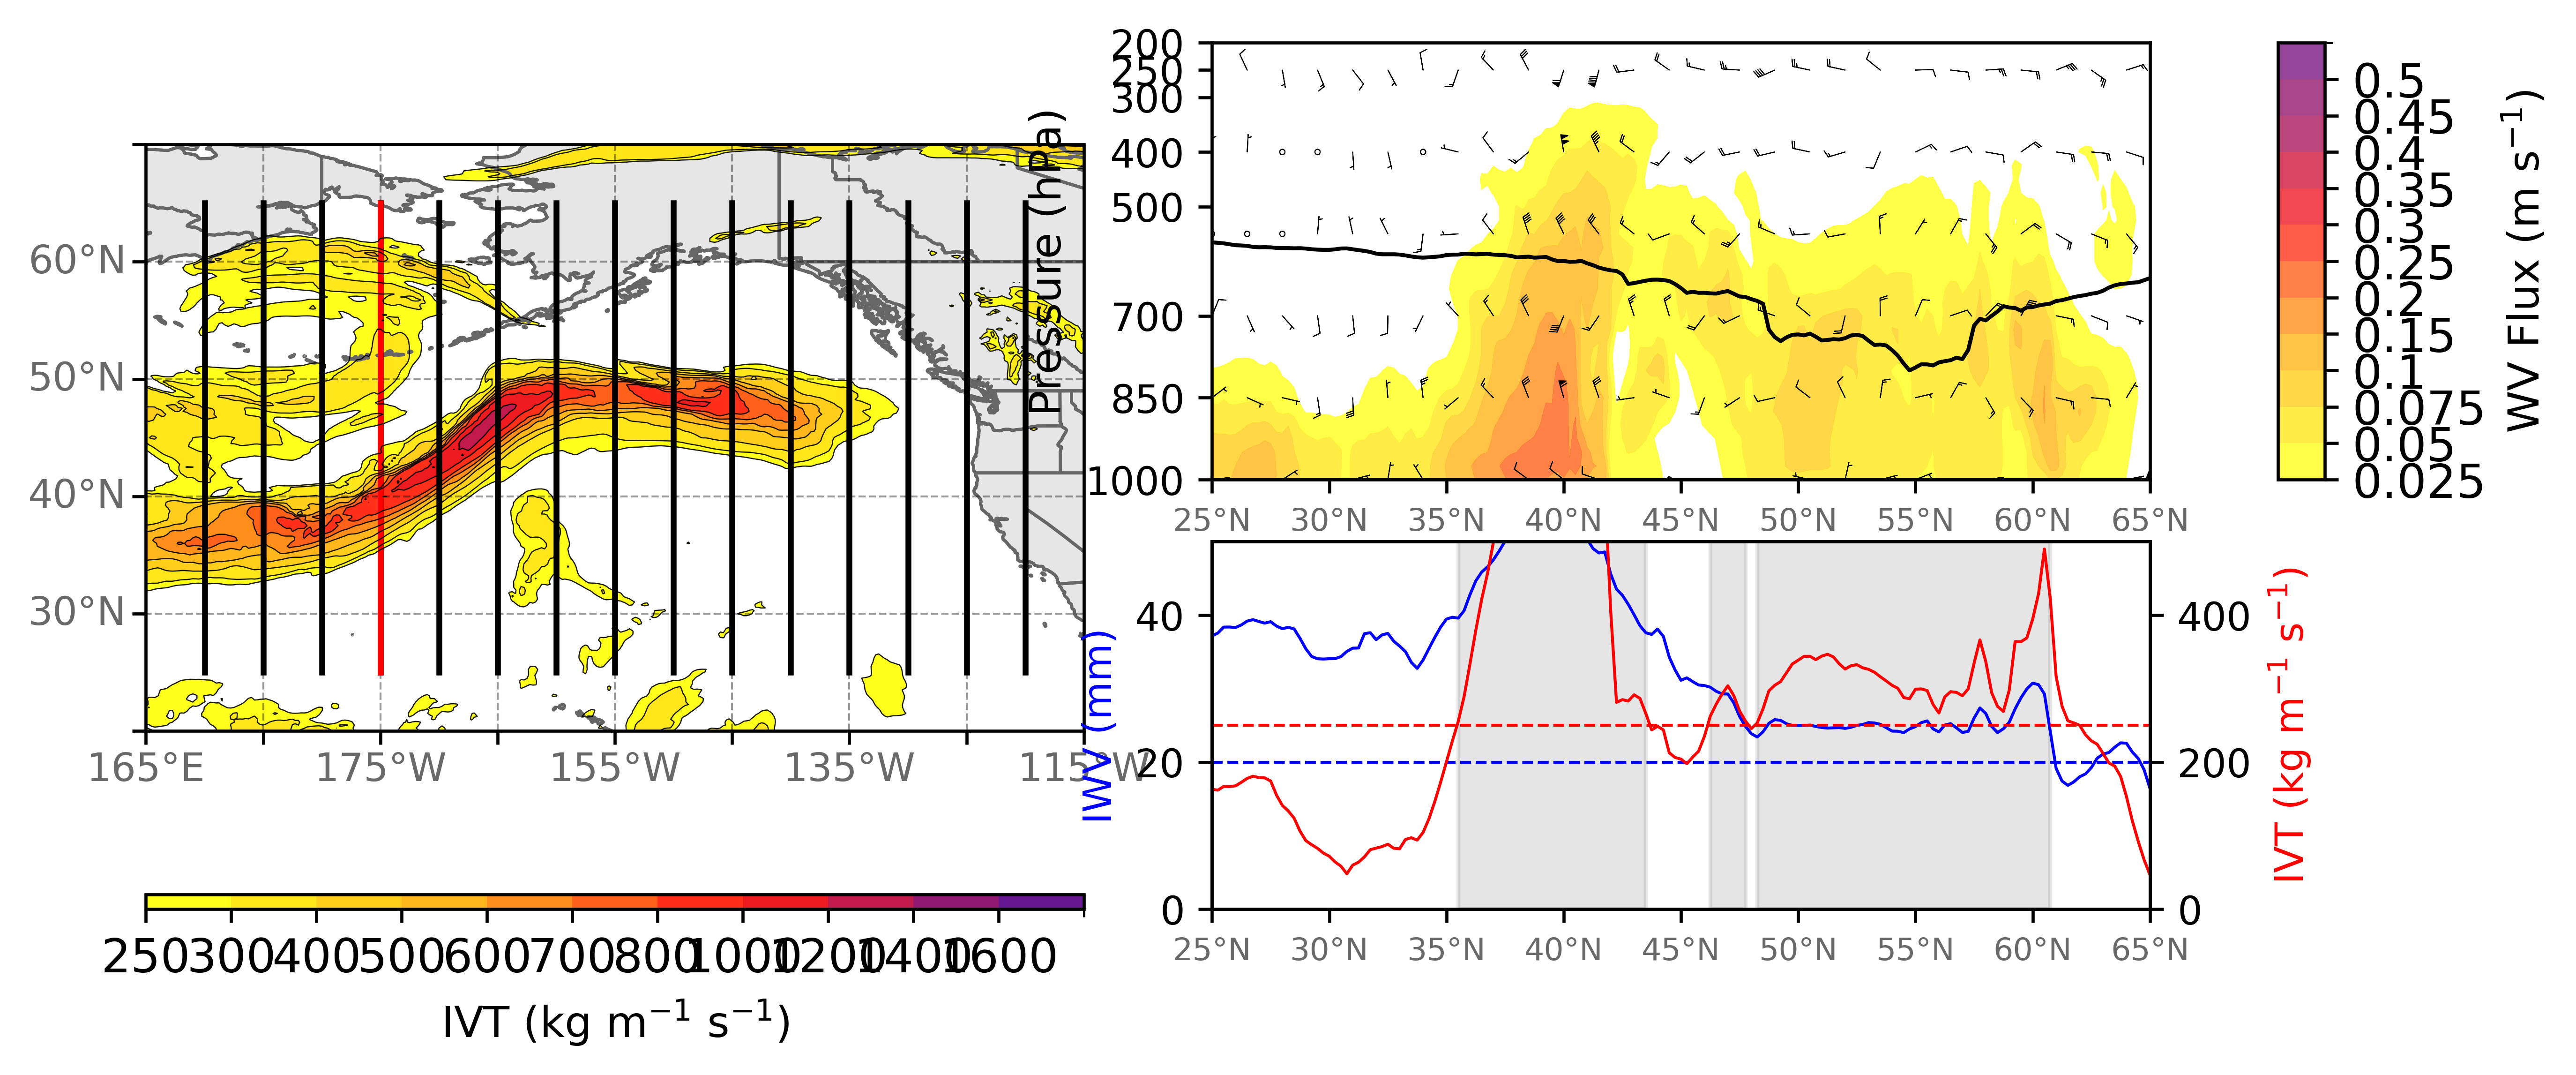

In [14]:
nrows = 3
ncols = 3
kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1.5, 1, 0.05], width_ratios = [1, 1, 0.05], wspace=0.2, hspace=0.25)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(10.0, 4.0))
fig.dpi = 600
fname = 'test'
fmt = 'png'

####################
### PLOT IVT MAP ###
####################

ax = fig.add_subplot(gs[0:2, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, grid=True)
ax.set_extent(ext, datacrs)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

## filled contour (IVT)
lats = ds.latitude.values
lons = ds.longitude.values
data = ds.ivt.values
cmap, norm, bnds, cbarticks, cbarlbl = ccmaps.cmap('ivt') # get cmap from our custom function

cf = ax.contourf(lons, lats, data, transform=datacrs, levels=bnds, cmap=cmap, norm=norm, alpha=0.9)

## contour lines (IVT)
cs = ax.contour(lons, lats, data, transform=datacrs, levels=bnds, colors=['black'], linewidths=0.3, alpha=0.9, zorder=100)

## black lines where possible cross sections are
for i, line in enumerate(line_lst):
    ax.plot([line[1], line[3]], [line[0], line[2]], color='k', transform=datacrs, zorder=3)
        
## red line where current cross section is showing
ax.plot([current_line[1], current_line[3]], [current_line[0], current_line[2]], color='r', transform=datacrs, zorder=3)

## color bar
cbax = fig.add_subplot(gs[-1, 0]) # colorbar axis (first row, last column)
cbarticks = list(itertools.compress(bnds, cbarticks)) ## this labels the cbarticks based on the cmap dictionary
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cbarticks)
cb.set_label(cbarlbl, fontsize=11)
cb.ax.tick_params(labelsize=12)

#####################
### CROSS SECTION ###
#####################
ax = fig.add_subplot(gs[0, 1])

## y-axis is pressure
## x-axis is latitude

xs = np.arange(0, len(cross.latitude), 1) # how many coordinate values
ys = cross.pressure.values
terline = cross.sfc_pressure.values / 100. ## convert from Pa to hPa
ht_fill = ax.fill_between(xs, 1000., terline, facecolor='0.9', edgecolor='k', zorder=10)

# Filled contours (WV flux)
cmap, norm, bnds, cbarticks, cbarlbl = ccmaps.cmap('wvflux') # get cmap from our custom function
cf = ax.contourf(xs, ys, cross.wvflux.values, levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither', zorder=-1)
plt.gca().invert_yaxis()
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Pressure (hPa)", fontsize=11)
ax.set_ylim(1000, 200)
ax.set_yticks([1000., 850., 700., 500., 400., 300., 250., 200.])

## add freezing level
freeze_line = ax.plot(xs, cross.freezing_level, c='k', lw=1.)

# zonal wind vectors
dw = 6 # how often to plot vector
# ax.quiver(xs[::dw], ys[::dw], cross.ua_cross.values[::dw, ::dw], cross.wa_cross.values[::dw, ::dw]*100, color='grey', alpha=0.8, width=0.002)
ax.barbs(xs[::dw], ys[::dw], cross.u.values[::dw, ::dw], cross.w.values[::dw, ::dw]*100, linewidth=0.25, length=3)

x_ticks = np.arange(len(xs))
x_labels = [u"{:.0f}\N{DEGREE SIGN}N".format(cross.latitude.values[i]) for i in x_ticks]
# set the frequency of xtick labels
skip = 20
ax.set_xticks(x_ticks[0::skip])
ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[0::skip]], fontsize=6, **kw_ticklabels)

# # Add color bar
cbax = fig.add_subplot(gs[0, -1]) # colorbar axis
# cbarticks = norm[::1]
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right', ticks=cbarticks)
cb.set_label(cbarlbl, fontsize=11)
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticklabels(['{:g}'.format(x) for x in cbarticks]) # force cbartick labels to drop trailing zeros

###################
### TIME SERIES ###
###################
ax = fig.add_subplot(gs[1:, 1])

ax.plot(xs, cross.iwv.values, color='blue', linewidth=0.75)
ax.set_ylabel('IWV (mm)', fontsize=10., color='blue')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(0,50)
ax.axhline(y=20.0, color='blue', linestyle='--', linewidth=0.75)
ax.set_xlim(0, xs[-1])

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(xs, cross.ivt.values, color='red', linewidth=0.75)
ax2.set_ylabel('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=10., color='red')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0,500)
ax2.axhline(y=250.0, color='red', linestyle='--', linewidth=0.75)
ax2.set_xlim(0, xs[-1])

x_ticks = np.arange(len(xs))
x_labels = [u"{:.0f}\N{DEGREE SIGN}N".format(cross.latitude.values[i]) for i in x_ticks]
# set the frequency of xtick labels
skip = 20
ax.set_xticks(x_ticks[0::skip])
ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[0::skip]], fontsize=6, **kw_ticklabels)

for i in range(len(arr)):
    ax.axvspan(arr.iloc[i][0], arr.iloc[i][1], color='grey', alpha=0.2, lw=None)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

In [32]:
from datetime import datetime, timedelta

pytimeinit = model_data.attrs["init"].astype('datetime64[s]').astype(datetime)
pytimeinit = pytimeinit.strftime('%H UTC %d %b %Y')
print(pytimeinit)
pytimevalidtime = model_data.attrs["valid_time"].astype('datetime64[s]').astype(datetime)
print(pytimevalidtime)

12 UTC 22 Jul 2024
2024-07-23 00:00:00


In [2]:

mapax.set_title(ulc_title.format(model_name=model_data.attrs["model"])+ "\n" +llc_title.format(init_time=datetime.strftime(pytimeinit, '%H UTC %d %b %Y')) ,loc="left")
mapax.set_title(lrc_title.format(lead_time=leadtime, valid_time=datetime.strftime(pytimevalidtime, '%H UTC %d %b %Y')), loc="right")

In [33]:
import glob
import re

year = pd.Timestamp.today().year
path_to_data = '/data/downloaded/Forecasts/GFS_025d/{0}/*'.format(year)
print(path_to_data)

list_of_files = glob.glob(path_to_data)
fpath = max(list_of_files, key=os.path.getctime)

regex = re.compile(r'\d+')
date_string = regex.findall(fpath)[-1]

fname = fpath + '/gfs_{0}_f039.grb'.format(date_string)
print(fname)


/data/downloaded/Forecasts/GFS_025d/2024/*
/data/downloaded/Forecasts/GFS_025d/2024/2024072212/gfs_2024072212_f039.grb


In [27]:
F_lst = [  6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
                 78, 84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
                 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222,
                 228, 234, 240]

for i, F in enumerate(F_lst):
    print(str(F).zfill(3))

## init hour can be 00 06 12 and 18
## these are respectively done downloading around 

006
012
018
024
030
036
042
048
054
060
066
072
078
084
090
096
102
108
114
120
126
132
138
144
150
156
162
168
174
180
186
192
198
204
210
216
222
228
234
240


In [6]:


####################
### READ 3D DATA ###
####################

path_to_data = '/data/downloaded/Forecasts/'
year = pd.Timestamp.today().year

if model_name == 'GFS':
    fname = path_to_data + 'GFS_025d/{0}/2024072212/gfs_2024072212_f012.grb'.format(year) ## TODO figure out a pythonic way to get latest date available
    
elif model_name == 'ECMWF':
    fname = path_to_data + 'ECMWF/NRT_data/2024071000/'
    
fname = 'gfs_2024072212_f012.grb'   
ds = xr.open_dataset(fname, engine='cfgrib', filter_by_keys={'typeOfLevel': 'isothermZero'})
ds
# var_lst = ['gh', 't', 'r', 'w', 'wz', 'u', 'v', 'absv', 'r', 'wz', 'absv', 'o3mr', 'tcc', 'clwmr', 'icmr', 'rwmr', 'snmr', 'grle']
# ds_q = xr.open_dataset(fname, engine='cfgrib', drop_variables=var_lst, filter_by_keys={'typeOfLevel': 'isobaricInhPa'}, backend_kwargs={"indexpath": ""})
# ds_q



<xarray.Dataset>
Dimensions:       (latitude: 721, longitude: 1440)
Coordinates:
    time          datetime64[ns] ...
    step          timedelta64[ns] ...
    isothermZero  float64 ...
  * latitude      (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude     (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time    datetime64[ns] ...
Data variables:
    gh            (latitude, longitude) float32 ...
    r             (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-07-22T12:41 GRIB to CDM+CF via cfgrib-0.9.1...

In [29]:
ds.step.values

numpy.timedelta64(43200000000000,'ns')

In [7]:
var_lst = ['r', 'wz', 'absv', 'o3mr', 'q', 'tcc', 'clwmr', 'icmr', 'rwmr', 'snmr', 'grle']
ds_uv = xr.open_dataset(fname, engine='cfgrib', drop_variables=var_lst, filter_by_keys={'typeOfLevel': 'isobaricInhPa'}, backend_kwargs={"indexpath": ""})
ds_uv

['gh', 't', 'r', 'w', 'wz', 'u', 'v', 'absv']

In [17]:
var_lst = ['vis', 'gust', 'hindex','orog','t','fco2rec','sdwe','sde','unknown','cpofp','cprat','prate','csnow','cicep',
           'cfrzr','crain','fsr','fricv','veg','slt','wilt','fldcp','SUNSD','lftx','cape','cin','4lftx', 'lsm','siconc', 'sit']
ds_sfc = xr.open_dataset(fname, engine='cfgrib', drop_variables=var_lst, filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'surface'}, backend_kwargs={"indexpath": ""})
ds_sfc

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] ...
Data variables:
    sp          (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-07-16T15:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [23]:
## merge uv and sfc datasets into one
test = xr.merge([ds_sfc, ds_uv])
test

<xarray.Dataset>
Dimensions:       (latitude: 721, longitude: 1440, isobaricInPa: 8)
Coordinates:
    time          datetime64[ns] 2024-07-16T18:00:00
    step          timedelta64[ns] 12:00:00
    surface       float64 ...
  * latitude      (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude     (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time    datetime64[ns] 2024-07-17T06:00:00
  * isobaricInPa  (isobaricInPa) float64 70.0 40.0 20.0 10.0 7.0 4.0 2.0 1.0
Data variables:
    sp            (latitude, longitude) float32 ...
    gh            (isobaricInPa, latitude, longitude) float32 ...
    t             (isobaricInPa, latitude, longitude) float32 ...
    q             (isobaricInPa, latitude, longitude) float32 ...
    w             (isobaricInPa, latitude, longitude) float32 ...
    u             (isobaricInPa, latitude, longitude) float32 ...
    v             (isobaricInPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-07-16T15:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [19]:
## TO DO - put this into a single function

####################
### READ 2D DATA ###
####################

path_to_data = '/data/downloaded/SCRATCH/cw3eit_scratch/'
fpath = path_to_data + 'GFS/'

## get the most recent file in the directory
list_of_files = glob.glob(fpath+'*.nc')
fname = max(list_of_files, key=os.path.getctime)

# pull the initialization date from the filename
regex = re.compile(r'\d+')
date_string = regex.findall(fname)
date_string = date_string[1]

## Forecast hour list
F_lst = np.arange(12, 120+12, 12) ## from 12 - 120 hours every 12 hours

## open the files with the correct forecast hour
ds_lst = []
for i, F in enumerate(F_lst):
    fname= fpath + 'GFS_IVT_{0}_F{1}.nc'.format(date_string, F)
    ds = xr.open_dataset(fname)
    ds = ds.rename({'lon_0': 'lon', 'lat_0': 'lat'}) # need to rename this to match GEFS
    ds_lst.append(ds)

## concat the dataset list into a single dataset
ds = xr.concat(ds_lst, pd.Index(F_lst, name="F"))
ds = ds.sel(F=12)
ds

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 281)
Coordinates:
  * lat      (lat) float32 10.0 10.25 10.5 10.75 11.0 ... 69.25 69.5 69.75 70.0
  * lon      (lon) float32 180.0 180.2 180.5 180.8 ... 249.2 249.5 249.8 250.0
    F        int64 12
Data variables:
    IVT      (lat, lon) float32 581.0 566.7 568.0 576.1 ... 144.6 141.8 138.1
    uIVT     (lat, lon) float32 -574.7 -560.7 -562.2 ... 107.9 101.1 95.18
    vIVT     (lat, lon) float32 -84.92 -82.15 -80.96 ... 96.28 99.38 100.1

In [21]:
lat_lst = np.arange(current_line[0], current_line[2], 0.25)
print(lat_lst)

[25.   25.25 25.5  25.75 26.   26.25 26.5  26.75 27.   27.25 27.5  27.75
 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75 30.   30.25 30.5  30.75
 31.   31.25 31.5  31.75 32.   32.25 32.5  32.75 33.   33.25 33.5  33.75
 34.   34.25 34.5  34.75 35.   35.25 35.5  35.75 36.   36.25 36.5  36.75
 37.   37.25 37.5  37.75 38.   38.25 38.5  38.75 39.   39.25 39.5  39.75
 40.   40.25 40.5  40.75 41.   41.25 41.5  41.75 42.   42.25 42.5  42.75
 43.   43.25 43.5  43.75 44.   44.25 44.5  44.75 45.   45.25 45.5  45.75
 46.   46.25 46.5  46.75 47.   47.25 47.5  47.75 48.   48.25 48.5  48.75
 49.   49.25 49.5  49.75 50.   50.25 50.5  50.75 51.   51.25 51.5  51.75
 52.   52.25 52.5  52.75 53.   53.25 53.5  53.75 54.   54.25 54.5  54.75
 55.   55.25 55.5  55.75 56.   56.25 56.5  56.75 57.   57.25 57.5  57.75
 58.   58.25 58.5  58.75 59.   59.25 59.5  59.75 60.   60.25 60.5  60.75
 61.   61.25 61.5  61.75 62.   62.25 62.5  62.75 63.   63.25 63.5  63.75
 64.   64.25 64.5  64.75]


In [38]:
test2.sp.values

array([ 97772.49, 100743.69, 101326.09, 101348.49, 101362.89, 101378.89,
       101393.29, 101407.69, 101420.49, 101438.09, 101447.69, 101450.89,
       101446.09, 101433.29, 101422.09, 101414.09, 101407.69, 101409.29,
       101412.49, 101423.69, 101430.09, 101436.49, 101454.09, 101471.69,
       101484.49, 101502.09, 101521.29, 101535.69, 101551.69, 101566.09,
       101574.09, 101582.09, 101591.69, 101580.49, 101562.89, 101553.29,
       101538.89, 101518.09, 101490.89, 101458.89, 101426.89, 101394.89,
       101362.89, 101337.29, 101316.49, 101298.89, 101281.29, 101278.09,
       101279.69, 101278.09, 101279.69, 101276.49, 101188.49, 101302.09,
       101311.69, 101314.89, 101330.89, 101356.49, 101383.69, 101406.09,
       101430.09, 101457.29, 101490.89, 101526.09, 101559.69, 101596.49,
       101641.29, 101681.29, 101718.09, 101758.09, 101809.29, 101863.69,
       101918.09, 101966.09, 102002.89, 102042.89, 102081.29, 102122.89,
       102166.09, 102196.49, 102220.49, 102255.69, 